# Baseline Model
As a simple model for this binary prediction, we choose logistic regression. This is both a conceptually simple and easy to interpret model, and can be extended to include more classes if necessary.

In this logistic regression model, we have to preprocess the data. For categorical variables this means creating dummy variables and for continuous variables, it means centering and scaling the data by the mean and standard deviation respectively. Many solvers that are optimized for large datasets perfrom better when the variables have similar ranges.

Then we get rid of variables involving arbitrary dates, such as date that the survey was administered, or the student's birth date. These will be difficult to handle in a logistic regression context. Variables such as 'parent's birth year' should work fine, as it is a single number.

In [1]:
#import relevant packages
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import re
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
#import student data from wrangling stage
filepath = '/Users/chrismalec/DS_Portfolio/CapstoneProjectOne/'
df_BY = pd.read_pickle(filepath + 'df_BY.pkl')
df_F3 = pd.read_pickle(filepath + 'df_F3.pkl')
df_weights = pd.read_pickle(filepath + 'df_weights.pkl')
labels = df_F3['X4EVERDROP']

import pickle
pickle_in = open(filepath+'number_labels.pkl',"rb")
number_labels = pickle.load(pickle_in)

In [3]:
#Create two groups of variables: continuous and discrete
cont_var = []
disc_var = []
for key in df_BY.columns:
    if list(number_labels[key].keys()) == ['desc']:
        cont_var.append(key)
    elif 'desc' not in list(number_labels[key].keys()):
        continue
    else:
        disc_var.append(key)
        
print('There are %f continuous variables and %f discrete variables' 
      %(len(cont_var),len(disc_var)))

There are 100.000000 continuous variables and 937.000000 discrete variables


In [4]:
#Fixing cont_var
cont_var = [x for x in cont_var if not re.search("YYYYMM",number_labels[x]['desc'])]
Student_ID = cont_var.pop(0)

## Handling missing data

At this point, there is not much missing data, but there are several different codes that refer to missing data. We will refer to most of these codes as nan, however non-response data is left as '-8' for discrete variables, as this represents a distinct category from the other types of missing data. All missing codes are converted to nan for continuous variables, as the values of the missing data can throw off the mean and standard deviations by quite a bit. For example, a score that ranges from 0 to 1 could have its mean significantly altered by only a few -8's.

In [5]:
#-4 means a follow through missing, 
#-5 is suppressed in public use data and was already cleaned,
#-6 is an abbreviated interview, 
#-7 is a legitimate skip, 
#-8 is a non-response,
#-9 is missing
for column in disc_var:
    df_BY.loc[df_BY[column] == -4,column] = np.nan
    df_BY.loc[df_BY[column] == -6,column] = np.nan
    df_BY.loc[df_BY[column] == -7,column] = np.nan
    #-8 is not labeled nan because it is an omission on the part of the subject, not the researcher
    df_BY.loc[df_BY[column] == -9,column] = np.nan
for column in cont_var:
    df_BY.loc[df_BY[column] == -4,column] = np.nan
    df_BY.loc[df_BY[column] == -6,column] = np.nan
    df_BY.loc[df_BY[column] == -7,column] = np.nan
    #Keeping -8 as is in continuous data would mess up the continuous variable means
    df_BY.loc[df_BY[column] == -8,column] = np.nan
    df_BY.loc[df_BY[column] == -9,column] = np.nan
    


## Preprocessing
The continuous variables are scaled and centered, since some solvers operate better when all variables have a similar average magnitude. We also make sure there are no rows or columns that contain only 'na' values. The few na values present in the data are imputed using the mode of each column, as this will work for both the categorical variables.

Finally, the independent variables are placed in an array, and the target variable is placed in a second array. We print out the number of dropouts and non-dropouts, and can see that we are dealing with unbalanced classes with the non-dropout category having nearly ten times more observations than the dropout category.

In [6]:
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df_BY[cont_var]),columns = cont_var)
df[disc_var] = df_BY[disc_var]

df = pd.get_dummies(df,prefix=disc_var,columns=disc_var,dummy_na=True)
df['Dropout'] = (labels == 1)
df = df.dropna(axis = 0, how = 'all')
df = df.dropna(axis = 1, how = 'all')

num_obs = df.shape[0]
mode_imputer = SimpleImputer(strategy = "most_frequent")
y = np.array(df.Dropout)
df = df.drop('Dropout', axis = 1)
X = mode_imputer.fit_transform(df)

In [8]:
print("There are",np.sum(y),"dropouts, and",np.sum(y == False),"non-droupouts in the dataset" )

There are 2714 dropouts, and 20789 non-droupouts in the dataset


## Training and Testing the Model

In order to make sure that our model can predict unseen data, we split it into testing and training sets. The training set will be used to cross_validate the hyperparameters for the model, while the testing set will be used to validate the model.

We first make a model with default parameters. Since the classes are unbalanced, the algorithm could conceivably get very high accuracy by under-estimating the number of dropouts. For example, about 14% of the observations contain a student who dropped out of high school, a model could therefore be 86% accurate by assuming everyone graduates. Therefore, we use a 'classification report' to assess the model's efficacy.

The 'precision', or the proportion of true positive to all positively identified variables, measures how many students the model correctly identified as dropped out compared to how many the model claims to have dropped out. The 'recall', or the propoportion of true positives to all observations that were actually true, measures how many students the model correctly identified as dropping out compared to the number that actually dropped out.

In [9]:
#Split into test/train
n_obs = df.shape[0]
n_train = round(0.67*n_obs)
shuffle_index = np.random.choice(df.index, size = n_obs, replace = False)
train_index = shuffle_index[:n_train]
test_index = shuffle_index[n_train:]

In [10]:
#Create X and y arrays
X_train = X[train_index,:]
X_test = X[test_index,:]

y_train = y[train_index]
y_test = y[test_index]

#train_weight = np.array(df_weights.loc[train_index,'W1STUDENT'])
train_weight = np.array(df_weights.loc[train_index,'W4W1STUP1'])

In [11]:
#Train model with default parameters
model = LogisticRegression(solver = 'liblinear')
model.fit(X_train,
          y_train,
          sample_weight = train_weight)
y_predict = model.predict(X_test)

print(classification_report(y_test,y_predict,target_names = ['Non-Dropout','Dropout']))

              precision    recall  f1-score   support

 Non-Dropout       0.92      0.78      0.84      6828
     Dropout       0.23      0.47      0.31       928

   micro avg       0.74      0.74      0.74      7756
   macro avg       0.57      0.63      0.57      7756
weighted avg       0.83      0.74      0.78      7756



## Tuning and Optimizing the Model

In logistic regression, the regularization constant 'C' is the only major parameter. We are also free to choose either an 'L1' or an 'L2' penalty referring to what power in the variables we use to calculate the regularization parameter. We will keep track of the testing and training error as well as the precision and recall. Again, with unbalanced classes, the testing and training error may not give a clear indication of which parameters are optimal, so we will use precision and recall to make a final decision.

In [15]:
#Create models
Cs = np.geomspace(1e-7,1e1,17)
models_L1 = [LogisticRegression(C = C,solver = 'liblinear',penalty = 'l1') for C in Cs]
models_L2 = [LogisticRegression(C = C,solver = 'liblinear',penalty = 'l2') for C in Cs]
models = models_L1 + models_L2

In [17]:
#Optimization
from sklearn.model_selection import KFold

df_cv = pd.DataFrame(data = {'C':[],
                            'penalty':[],
                            'train_error':[],
                            'test_error':[],
                            'precision':[],
                            'recall':[]})
for model in models:
    kf = KFold(n_splits=3,shuffle = True, random_state = 673)
    train_scores = []
    test_scores = []
    precisions = []
    recalls = []
    for traincv_index, testcv_index in kf.split(X_train,y_train):
        model.fit(X_train[traincv_index,:],
                  y_train[traincv_index],
                  sample_weight = train_weight[traincv_index])
        
        y_testcv = y_train[testcv_index]
        y_predictcv = model.predict(X_train[testcv_index,:])
        
        report = classification_report(y_testcv,y_predictcv,output_dict = True)
        
        precisions.append(report['True']['precision'])
        recalls.append(report['True']['recall'])
        train_scores.append(model.score(X_train[traincv_index,:],y_train[traincv_index]))
        test_scores.append(model.score(X_train[testcv_index,:],y_train[testcv_index]))
    
    row = [model.get_params()['C'],
          model.get_params()['penalty'],
          1-np.median(train_scores),
          1-np.median(test_scores),
          np.median(precisions),
          np.median(recalls)]
    df_cv = df_cv.append(pd.DataFrame([row],columns = df_cv.columns),ignore_index = True)

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/p

## Plotting and Choosing the Optimal Model

Optimal is always a trade-off between several competing needs. We would like a model that is as accurate as possible while performing well on unseen data. When deciding on how to proceed with a tradeoff, it is important to identify the consequences of certain types of mistakes. Guidance from a school or school district would be important when deciding the sensible goals for precision and recall numbers.

In our specific case, identifying a student at risk for dropping out when that student is actually not at risk is acceptable as long as this does not happen so often as to undermine interventions. However, missing an identification of a student who is actually at risk for dropping out is undesirable, as an intervention may have helped this student. Therefore, we would prefer better recall over better precision.

We see from the graphs below for the L2 penalty that the test error rises rapidly for C > 1e-5. This is also the point at which precision and recall are about the same. However, most values of C have much lower precision than recall.  For the L1 penalty, the error rises for C > 1e-3, but not as rapidly as for the L2. Recall is lower for the L1 penalty, but it is still on par with the L2 penalty and does have as big a loss in precision.

Taking all this into account, we select C = 1e-3 with an L1 penalty to maintain low test error and maximize recall.

In [19]:
#Create dataframes conducive to plots
df_plot1 = pd.melt(df_cv,id_vars = ['C','penalty'],value_vars = ['train_error','test_error'],value_name = 'error',var_name = 'error_type')
df_plot1['logC'] = np.log10(df_plot1.C)
df_plot2 = pd.melt(df_cv,id_vars = ['C','penalty'],value_vars = ['precision','recall'],value_name = 'classification',var_name = 'class_type')
df_plot2['logC'] = np.log10(df_plot2.C)

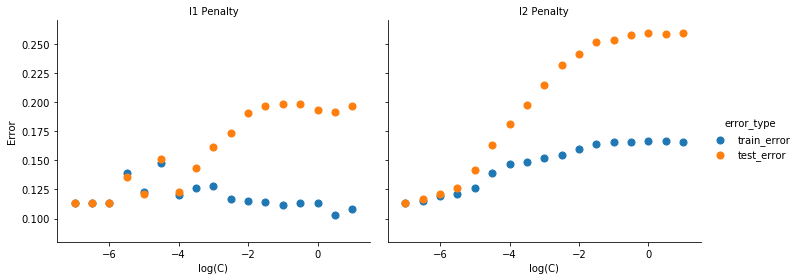

In [20]:
import seaborn as sns
g = sns.FacetGrid(df_plot1,
                  col = 'penalty',
                  hue = 'error_type',
                  height = 4,
                  aspect = 1.25
                 )
g = g.map(plt.scatter,
          'logC',
          'error',
          s = 50
         )
g = g.set_axis_labels('log(C)','Error')
g = g.set_titles('{col_name} Penalty')
g = g.add_legend()
plt.show()

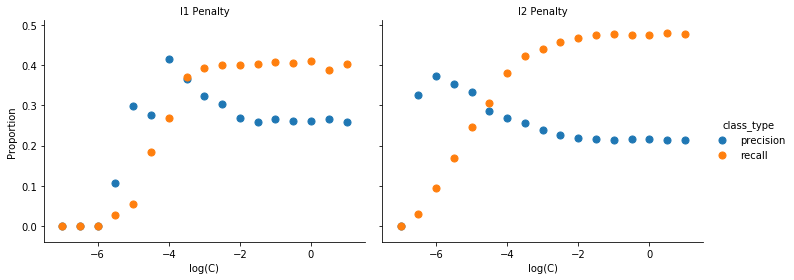

In [21]:
g = sns.FacetGrid(df_plot2,
                  col = 'penalty',
                  hue = 'class_type',
                  height = 4,
                  aspect = 1.25
                 )
g = g.map(plt.scatter,
          'logC',
          'classification',
          s = 50
         )
g = g.set_axis_labels('log(C)','Proportion')
g = g.set_titles('{col_name} Penalty')
g = g.add_legend()
plt.show()

In [25]:
#Train model with optimal parameters and apply to test set
model = LogisticRegression(solver = 'liblinear', C = 1e-3, penalty = 'l1')
model.fit(X_train,
          y_train,
          sample_weight = train_weight)
y_predict = model.predict(X_test)

print(classification_report(y_test,y_predict,target_names = ['Non-Dropout','Dropout']))

              precision    recall  f1-score   support

 Non-Dropout       0.91      0.89      0.90      6828
     Dropout       0.32      0.39      0.35       928

   micro avg       0.83      0.83      0.83      7756
   macro avg       0.62      0.64      0.63      7756
weighted avg       0.84      0.83      0.84      7756



## Interpretation of Model Coefficients

We would now like to actually see what the model says about our problem. The interpretation of the coefficients in logistic regression is straightforward, particularly for a binary outcome. Each coefficient is related to the odds of changing from the non-dropout class to the drop out class for a unit change in the variable. So for a variable $\beta$:

$e^{\beta} = \frac{Prob(dropout)}{1-Prob(dropout)}$

We therefore look at the top five negative coefficients, meaning the items associated with lowering the odds of dropping out, and the top five positive coefficients, meaning the items associated with raising the odds of dropping out. We also look at three neutral coefficients, which don't really effect outcomes one way or the other.

In [64]:
#Find top five positive, top five negative, 
coef_rank = np.argsort(model.coef_[0,:])
neg = coef_rank[:5]
pos = coef_rank[-5:]
mid = int(len(coef_rank)/2)
neut = coef_rank[(mid-2):(mid+1)]
pos_values = model.coef_[0,pos]
neg_values = model.coef_[0,neg]
mid_values = model.coef_[0,neut]
plot_odds = np.exp(np.concatenate((neg_values,mid_values,pos_values)))

In [52]:
print('The top five factors increasing dropout likelihood are:')
for p in pos:
    cat = df.columns[p].split('_')
    print(' '.join(number_labels[cat[0]]['desc'].split()[2:]),'-',cat[1])
print('\n')
print('The top five factors decreasing dropout likelihood are:')
for n in neg:
    cat = df.columns[n].split('_')
    print(' '.join(number_labels[cat[0]]['desc'].split()[2:]),'-',cat[1])
print('\n')
print('Three neutral factors for dropout likelihood are:')
for n in neut:
    cat = df.columns[n].split('_')
    print(' '.join(number_labels[cat[0]]['desc'].split()[2:]),'-',cat[1])

The top five factors increasing dropout likelihood are:
When 9th grader will start education after high school - 4.0
How often parent contacted by school about poor attendance - 4.0
9th grader sees himself/herself as a math person - 1.0
9th grader thinks even if he/she studies he/she won't get into college - nan
Whether 9th grader has ever stopped attending school for a month or more - 1.0


The top five factors decreasing dropout likelihood are:
9th grader's month of birth - 12.0
Importance of achievement in MS courses for 9th grade science placement - 1.0
School counseling program's most emphasized goal - 1.0
9th grader's year of birth - 6.0
Whether 9th grader has ever stopped attending school for a month or more - 0.0


Three neutral factors for dropout likelihood are:
School's principal deals w/ outside pressures interfering with teaching - 3.0
School's principal deals w/ outside pressures interfering with teaching - -8.0
Cannot do much b/c student motivation/performance depends on

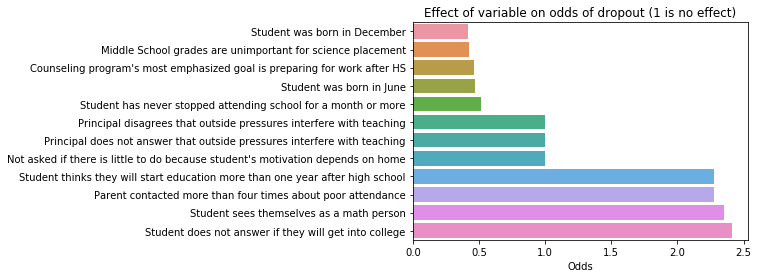

In [67]:
pos_labels = ['Student thinks they will start education more than one year after high school',
              'Parent contacted more than four times about poor attendance',
              'Student sees themselves as a math person',
              'Student does not answer if they will get into college',
              'Student has stopped attending school for a month or more'
              ]
mid_labels = ['Principal disagrees that outside pressures interfere with teaching',
              'Principal does not answer that outside pressures interfere with teaching',
              'Not asked if there is little to do because student\'s motivation depends on home',
             ]
neg_labels = ['Student was born in December',
              'Middle School grades are unimportant for science placement',
              'Counseling program\'s most emphasized goal is preparing for work after HS',
              'Student was born in June',
              'Student has never stopped attending school for a month or more'
             ]
    
plot_labels = neg_labels + mid_labels + pos_labels
ax = sns.barplot(y = plot_labels[0:12], x = plot_odds[0:12],order = plot_labels[0:12],orient = 'h')
plt.title('Effect of variable on odds of dropout (1 is no effect)')
plt.xlabel('Odds')
plt.show()

## Conclusions

We can see that there are several important factors that lower the odds of dropping out, such as how students are placed into their 9th grade science program and a counseling program that prepares students for work after high school. Being born in December or June also strongly decreases the odds of dropping out by 50%, which is most likely a confounding variable for something else not captured by the model.

There are also several factors that double the odds of dropping out of high school, such as a student believing they will start post-secondary education more than a year after high school and parents being contacted frequently about poor attendance.

However, one variable has been left off the graph, when we add this variable we can see that if a student has stopped attending school for more than a month, their odds of dropping out increases by a factor of 3000. To some extent, this is a self-fulfilling prophecy, since all dropouts will begin with an absence of a month or more, however if this was a trivial dependence, the model would have easily reached 100% accuracy, so this is probably an important identifier. Unfortunately, it may be a identifier that shows up too late.

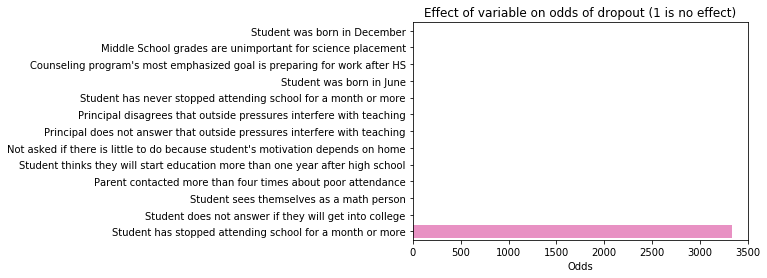

In [68]:
ax = sns.barplot(y = plot_labels, x = plot_odds,order = plot_labels,orient = 'h')
plt.title('Effect of variable on odds of dropout (1 is no effect)')
plt.xlabel('Odds')
plt.show()